In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib as mpl
import os 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Conv1D, Conv2D, GRU
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras

In [2]:
plt.rcParams['font.family'] = 'NanumbarunGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
samsung = pd.read_csv('./data/SSE2015-01-01_2020-06-30.csv')
samsung.drop('Change', axis=1, inplace=True)
samsung = samsung[samsung['Open']!=0]
samsung.index = pd.to_datetime(samsung.Date)
samsung.drop('Date', axis=1, inplace=True)
samsung = samsung['2018-01-01':]

In [4]:
def investing_preprocessing(filepath):
    data = pd.read_csv(str(filepath))[::-1].reset_index(drop=True)
    if '날짜' in data.keys():
        data['날짜'] = data['날짜'].str.replace('([0-9]{4})년 ([0-9]{2})월 ([0-9]{2})일', '\\1-\\2-\\3')
        data.rename(columns={'날짜':'Date'}, inplace=True)
    data.index = pd.to_datetime(data['Date'])
    data.drop('Date', axis=1, inplace=True)
    return data

def process_Volume(volume):
    if volume == '-':
        return np.nan
    
    scale = volume[-1]
    val = float(volume[:-1])
    
    if scale == 'K':
        val = val*1e3
    elif scale == 'M':
        val = val*1e6
    elif scale == 'B':
        val = val*1e9
        
    return val

In [5]:
nasdaq = investing_preprocessing('./data/NASDAQ.csv')
nasdaq['거래량'] = nasdaq['거래량'].apply(process_Volume)
nasdaq.keys()
nasdaq = nasdaq['종가'].str.replace(",", '').astype(float)
nasdaq.head(2)

Date
2018-01-02    7006.90
2018-01-03    7065.53
Name: 종가, dtype: float64

In [7]:
exchange = investing_preprocessing('./data/exchange.csv')
exchange = exchange['Open'].str.replace(",", '').astype(float)[::-1]['2018-01-01':]
exchange.head(2)

Date
2018-01-01    1067.38
2018-01-02    1067.23
Name: Open, dtype: float64

In [8]:
Semiconductor = investing_preprocessing('./data/Philadelphia Semiconductor Index.csv')
Semiconductor = Semiconductor['종가'].str.replace(",", '').astype(float)['2018-01-01':]
Semiconductor.head(2)

Date
2018-01-02    1287.70
2018-01-03    1309.86
Name: 종가, dtype: float64

In [9]:
foreign = pd.read_excel('./data/SSEforeign2017-2020.xlsx')
foreign.index = pd.to_datetime(foreign['Date'])
foreign.drop('Date', axis=1, inplace=True)
foreign['기관 순매매량'] = foreign['기관 순매매량'].str.replace(",", '').astype(float)
foreign['외국인 순매매량'] = foreign['외국인 순매매량'].str.replace(",", '').astype(float)
foreign = foreign[['기관 순매매량', '외국인 순매매량']][::-1]['2018-01-01':]
foreign.head(2)

,기관 순매매량,외국인 순매매량
Date,,
2018-01-02,-23405.0,-18019.0
2018-01-03,-47563.0,45759.0


In [10]:
KOSPI = investing_preprocessing('./data/KOSPI.csv')
KOSPI = KOSPI['종가'].str.replace(",", '').astype(float)
KOSPI.head(2)

Date
2018-01-02    2479.65
2018-01-03    2486.35
Name: 종가, dtype: float64

In [11]:
Korea_bond_1year = investing_preprocessing('./data/KOREA_bond_1year.csv')
Korea_bond_1year = Korea_bond_1year['종가']['2018-01-01':]
Korea_bond_1year.head(2)

Date
2018-01-02    1.816
2018-01-03    1.792
Name: 종가, dtype: float64

In [12]:
PBR_PER_ROE = investing_preprocessing("./data/PBR_PER_ROE.csv")
PBR_PER_ROE = PBR_PER_ROE[['PBR', 'PER', 'ROE']][::-1]['2018-01-01':]
PBR_PER_ROE.head(2)

,PBR,PER,ROE
Date,,,
2018-01-02,0.037682,0.265244,0.142064
2018-01-03,0.038125,0.268364,0.142064


In [13]:
inputdata = pd.concat([samsung, nasdaq, exchange, Semiconductor, foreign, KOSPI, Korea_bond_1year, PBR_PER_ROE], axis=1)

In [14]:
inputdata.columns = ["Open", "High", "Low", "Close", "Volume", "nasdaq", 
                     "exchange", "Semiconductor", "foreign", "institution", 
                     "KOSPI", "Korea_bond_1year", "PBR", "PER", "ROE"]

In [15]:
inputdata.dropna(subset=['Close'], inplace=True)

In [16]:
inputdata.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume               0
nasdaq              19
exchange             0
Semiconductor       19
foreign              0
institution          0
KOSPI                0
Korea_bond_1year     1
PBR                  0
PER                  0
ROE                  0
dtype: int64

In [17]:
inputdata.dropna(inplace=True)

In [18]:
inputdata[inputdata.nasdaq.isnull()].index == inputdata[inputdata.Semiconductor.isnull()].index

array([], dtype=bool)

In [19]:
inputdata[inputdata.nasdaq.isnull()].index

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

In [20]:
inputdata[inputdata.nasdaq.isnull()].index.day_name()

Index([], dtype='object', name='Date')

In [21]:
inputdata.head(2)

,Open,High,Low,Close,Volume,nasdaq,exchange,Semiconductor,foreign,institution,KOSPI,Korea_bond_1year,PBR,PER,ROE
Date,,,,,,,,,,,,,,,
2018-01-02,51380.0,51400.0,50780.0,51020.0,169485.0,7006.90,1067.23,1287.70,-23405.0,-18019.0,2479.65,1.816,0.037682,0.265244,0.142064
2018-01-03,52540.0,52560.0,51420.0,51620.0,200270.0,7065.53,1062.88,1309.86,-47563.0,45759.0,2486.35,1.792,0.038125,0.268364,0.142064


In [21]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(inputdata)

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = inputdata.keys()

df_scaled.head()

,Open,High,Low,Close,Volume,nasdaq,exchange,Semiconductor,foreign,institution,KOSPI,Korea_bond_1year,PBR,PER,ROE
0,0.567413,0.5520,0.572074,0.546076,0.000429,0.206675,0.058961,0.233419,0.711073,0.339060,0.896068,0.855892,0.003531,0.001045,0.693746
1,0.614664,0.5984,0.598357,0.570221,0.000915,0.221562,0.037834,0.257113,0.710345,0.340881,0.901942,0.839731,0.003776,0.001080,0.693746
2,0.597556,0.5832,0.566324,0.548491,0.001446,0.224705,0.047353,0.265004,0.710580,0.340335,0.884503,0.845118,0.003556,0.001048,0.693746
3,0.564155,0.5808,0.589322,0.590342,0.000747,0.239597,0.040019,0.274060,0.711953,0.339847,0.911736,0.832323,0.003980,0.001110,0.693746
4,0.608961,0.5968,0.601643,0.586318,0.000400,0.244886,0.034871,0.284570,0.711238,0.339833,0.925553,0.837710,0.003940,0.001104,0.693746


In [22]:
df_scaled.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
nasdaq              0
exchange            0
Semiconductor       0
foreign             0
institution         0
KOSPI               0
Korea_bond_1year    0
PBR                 0
PER                 0
ROE                 0
dtype: int64

In [23]:
TEST_SIZE = 100
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [24]:
def make_dataset(data, label, window_size=365, predsize = None):
    feature_list = []
    label_list = []

    if isinstance(predsize, int):
        for i in range(len(data) - (window_size + predsize)):
            feature_list.append(np.array(data.iloc[i:i+window_size]))
            label_list.append(np.array(label.iloc[i+window_size:i+window_size+predsize]))
    else:
        for i in range(len(data) - window_size):
            feature_list.append(np.array(data.iloc[i:i+window_size]))
            label_list.append(np.array(label.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)

In [25]:
feature_cols = inputdata.columns
label_cols = ["Close"]

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
print(test_feature.shape, test_label.shape)

(376, 20, 15) (376, 1)
(94, 20, 15) (94, 1)
(80, 20, 15) (80, 1)


In [26]:
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape = [train_feature.shape[1], train_feature.shape[2]]))
model.add(GRU(128))
# model.add(Dense(32, activation='elu'))
model.add(Dense(1))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 128)           55680     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 154,881
Trainable params: 154,881
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_path = './trained_model'
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
early_stop = EarlyStopping(monitor='val_loss', patience=30)
filename = os.path.join(model_path, 'KISTI_proj_GRU_15f.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [29]:
history = model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Train on 376 samples, validate on 94 samples
Epoch 1/100
256/376 [===================>..........] - ETA: 1s - loss: 0.0390
Epoch 00001: val_loss improved from inf to 0.03531, saving model to ./trained_model\KISTI_proj_GRU_15f.h5
376/376 [==============================] - 4s 12ms/sample - loss: 0.0292 - val_loss: 0.0353
Epoch 2/100
256/376 [===================>..........] - ETA: 0s - loss: 0.0194
Epoch 00002: val_loss did not improve from 0.03531
376/376 [==============================] - 0s 653us/sample - loss: 0.0196 - val_loss: 0.0364
Epoch 3/100
256/376 [===================>..........] - ETA: 0s - loss: 0.0112
Epoch 00003: val_loss did not improve from 0.03531
376/376 [==============================] - 0s 610us/sample - loss: 0.0095 - val_loss: 0.0971
Epoch 4/100
256/376 [===================>..........] - ETA: 0s - loss: 0.0069
Epoch 00004: val_loss did not improve from 0.03531
376/376 [==============================] - 0s 610us/sample - loss: 0.0085 - val_loss: 0.1195
Epoch 5/100
2

Epoch 35/100
256/376 [===================>..........] - ETA: 0s - loss: 0.0017
Epoch 00035: val_loss did not improve from 0.01221
376/376 [==============================] - 0s 578us/sample - loss: 0.0017 - val_loss: 0.0124
Epoch 36/100
256/376 [===================>..........] - ETA: 0s - loss: 0.0016
Epoch 00036: val_loss improved from 0.01221 to 0.01163, saving model to ./trained_model\KISTI_proj_GRU_15f.h5
376/376 [==============================] - 0s 676us/sample - loss: 0.0016 - val_loss: 0.0116
Epoch 37/100
256/376 [===================>..........] - ETA: 0s - loss: 0.0016
Epoch 00037: val_loss improved from 0.01163 to 0.01107, saving model to ./trained_model\KISTI_proj_GRU_15f.h5
376/376 [==============================] - 0s 695us/sample - loss: 0.0016 - val_loss: 0.0111
Epoch 38/100
256/376 [===================>..........] - ETA: 0s - loss: 0.0016
Epoch 00038: val_loss improved from 0.01107 to 0.01104, saving model to ./trained_model\KISTI_proj_GRU_15f.h5
376/376 [===============

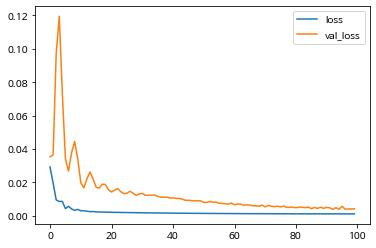

In [30]:
pd.DataFrame(history.history).plot()

In [31]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

In [32]:
pred.shape

(80, 1)

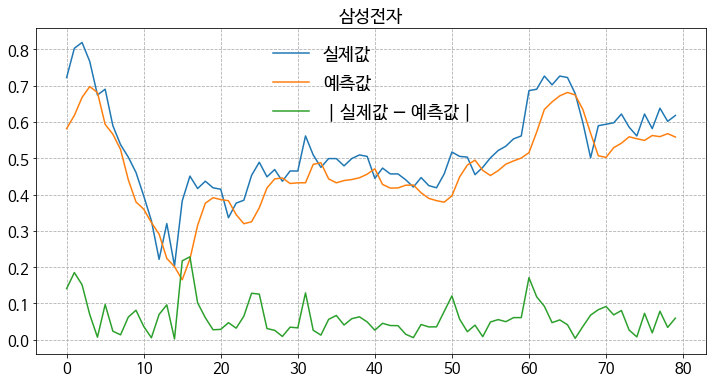

In [33]:
plt.figure(figsize=(12, 6))
plt.rc("font",size=15)
plt.plot(test_label, label='실제값')
plt.plot(pred, label='예측값')
plt.plot(np.sqrt((pred - test_label)**2), label='$\mid$실제값 $-$ 예측값$\mid$')
plt.legend(frameon=False, fontsize = 18)
plt.grid(ls='--')
plt.title("삼성전자")
# plt.savefig("./삼성전자주가예측.png", bbox_inches='tight')
plt.show()

In [34]:
def Naivemodel(data, predict_range):
    """
    마지막 값을 그대로 예측
    """
    pred = np.empty([len(data), predict_range])
    for i, j in enumerate(data):
        pred[i,:] = np.full(predict_range, j[-1, 3])
    return pred

### MSE

In [35]:
naive_data = Naivemodel(test_feature, 1)

In [36]:
np.mean(keras.losses.mean_squared_error(test_label, pred))

0.0059015844

In [37]:
np.mean(keras.losses.mean_squared_error(test_label, naive_data))

0.0027683201826654105

### Accuracy

In [38]:
test_sign = np.sign(test_label.flatten() - test_feature[:, -1, 3])
pred_sign = np.sign(pred.flatten() - test_feature[:, -1, 3])
sum(test_sign == pred_sign)/len(pred_sign)

0.525